In [1]:
import numpy as np

class Network:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1, B1):
        """
        Initialises the Network object
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.B1 = B1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition
        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if 0<state1<self.n1+1:
                    return self.L1*self.B1/(state1)
                else:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)

    def discretise_transition_matrix(self):
        """
        Disctetises the transition matrix
        """
        self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))

    def find_mean_time_to_absorbtion(self):
        """
        Finds the mean time to absorbtion
        """
        T = self.discrete_transition_matrix[:-1, :-1]
        S = np.linalg.inv(np.identity(len(T)) - T)
        steps2absorb = [sum([S[i,j] for j in range(len(S))]) for i in range(len(S))]
        time2absorb = [s*self.time_step for s in steps2absorb]
        self.mean_steps_to_absorbtion = {str(self.State_Space[i]): steps2absorb[i] for i in range(len(steps2absorb))}
        self.mean_time_to_absorbtion = {str(self.State_Space[i]): float(time2absorb[i]) for i in range(len(time2absorb))}

In [2]:
def analytical_time_to_deadlock(Lambda, mu, n, r11, beta):
    N = Network(n, mu, r11, Lambda, beta)
    N.find_mean_time_to_absorbtion()
    return N.mean_time_to_absorbtion['0']

In [8]:
import ciw
from tqdm import tqdm_notebook

In [4]:
def baulkingprobability(N, beta=0.5):
    if N == 0:
        p = 0.0
    else:
        p = 1 - beta / N
    return p

In [5]:
def simulate_time_to_deadlock(Lambda, mu, n, r11, beta, seed=0):
    
    def balk_func(N):
        return baulkingprobability(N, beta=beta)
    
    params = {
        "Arrival_distributions": [["Exponential", Lambda]],
        "Service_distributions": [["Exponential", mu]],
        "Transition_matrices": [[r11]],
        "Queue_capacities": [n],
        "Number_of_servers": [1],
        "Baulking_functions": [balk_func]
    }
    
    ciw.seed(seed)
    N = ciw.create_network(params)
    Q = ciw.Simulation(N, deadlock_detector="StateDigraph")
    Q.simulate_until_deadlock()
    return Q.times_to_deadlock[((0, 0), )]

In [12]:
analytical_times = [analytical_time_to_deadlock(3.0, 3.0, 2, 0.6, b) for b in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]

In [11]:
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
times = []
for b in tqdm_notebook(betas):
    times.append([])
    for i in tqdm_notebook(range(10000)):
        times[-1].append(simulate_time_to_deadlock(3.0, 3.0, 2, 0.6, b, seed=i))

In [33]:
%matplotlib inline
import numpy as np

In [34]:
times_no_outliers = []
for data_series in times:
    q75, q25 = np.percentile(data_series, [75 ,25])
    iqr = q75 - q25
    upper = q75 + (1.5*iqr)
    lower = q25 - (1.5*iqr)
    new_data = [obs for obs in data_series if obs > lower and obs < upper]
    times_no_outliers.append(new_data)

In [35]:
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set(style="whitegrid")

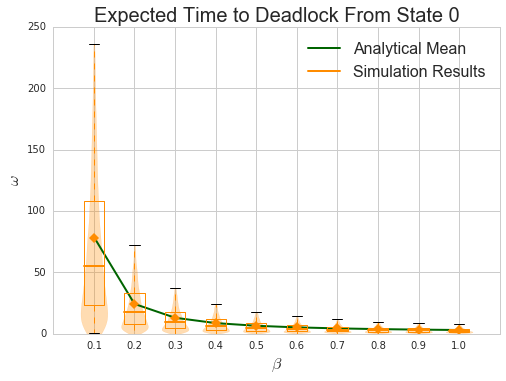

In [41]:
line_colour = 'darkgreen'
plot_colour = 'darkorange'

fig, ax = plt.subplots()
plt.plot(betas, analytical_times, linewidth=2, label='Analytical Mean', color=line_colour)
plt.plot([], [], 'r', linewidth=2, label='Simulation Results', color=plot_colour)
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=plot_colour)
bp = plt.boxplot(times, positions=betas, widths=0.05, meanprops=meanpointprops, meanline=False, showmeans=True, sym='')
for median in bp['medians']:
    median.set(color=plot_colour, linewidth=2)
pylab.setp(bp['boxes'], color=plot_colour)
pylab.setp(bp['whiskers'], color=plot_colour)


vp = plt.violinplot(times_no_outliers, widths=0.066, positions=betas, showmeans=False, showmedians=False, showextrema=False)
pylab.setp(vp['bodies'], color=plot_colour)
plt.xlim([0, 1.1])
ax.set_xlabel(r'$\beta$', fontsize=16)
ax.set_ylabel(r'$\omega$', fontsize=16)
ax.set_title('Expected Time to Deadlock From State 0', fontsize=20)

plt.legend(loc=1, prop={'size':16})
plt.savefig("vary_beta.pdf")